<a href="https://colab.research.google.com/github/guzonghua/saavlabs/blob/main/Lab1/Lab1_Adversarial_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1.** This blog article and source code describes how to train a model for Traffic Sign Recognition through fine-tuning a pretrained MobileNetV3 Large model

Traffic Sign Recognition using PyTorch and Deep Learning

https://debuggercafe.com/traffic-sign-recognition-using-pytorch-and-deep-learning/

**Update 20/11/2023: the blog author provides a pre-trained model model.pth. You may choose to use it in Step 2 instead of training your own model.**

If you choose to train your own model instead, please follow the following steps.

Optional: To save training time, you may use the MobileNetV3 Small model instead of MobileNetV3 Large:
https://pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_small.html

By changing these lines in model.py:  

    model = models.mobilenet_v3_small(pretrained=pretrained)
    ...
    # Change the final classification head.
    model.classifier[3] = nn.Linear(in_features=1024, out_features=num_classes)

(You may choose to design your own architecture, or start from a pretrained network, e.g., LeNet, AlexNet or ResNet, and perform transfer learning/fine-tuning.)

At the last step "Testing the Model and Visualizing Class Activation Maps (CAM)", please record the model accuracy (CAM is not important). Please save the trained DNN model to be used in Step 2. The purpose of this assignment is to obtain a DNN with reasonable accuracy, say >90%, not to obtain the highest accuracy, so do not spend a lot of time tuning hyperparameters.

Ref: PyTorch SAVING AND LOADING MODELS
https://pytorch.org/tutorials/beginner/saving_loading_models.html


**Step 2.** Follow the steps in "Chapter 3 - Adversarial examples, solving the inner maximization" in the tutorial "Adversarial Robustness - Theory and Practice" 2018 to create attack images:

https://adversarial-ml-tutorial.org/adversarial_examples/

Use your trained CNN, perform the following steps:

2.1 Untargeted attack using Fast Gradient Sign Method (FGSM), using the function fgsm().

2.2 Untargeted attack using Projected Gradient Descent, using the function pgd_linf() (You may use the Projected Steepest Descent variant to accelerate the process).

2.3 Targeted attack using Projected Gradient Descent, using the function pgd_linf_targ(), which aims to maximize logit of the target class y_targ and minimize logit of the true class y. You may choose any target class, but I suggest using "Speed Limit".

2.4 Targeted attack using Projected Gradient Descent, using the function pgd_linf_targ2(),  which  aims to maximize logit of the target class y_targ and minimize logit of all the other classes y'.
For each attack, report the accuracy of the attacked classifier on the testset, and show visualization of a few examples of successful attack (original image and attacked image).

**Submission instructions**: You may use either Google CoLab or your local machine. If you use CoLab, please send your CoLab web link. Otherwise, please submit an ipynb or Python file, along with a short report in PDF containing the test accuracy and visualization of examples, as well as any problems you encountered or any insights you want to share. You may write the report with WORD, or choose to embed the report within the ipynb file, execute it to show all results, then and print it as PDF.

**Git hub Code on: https://github.com/SpikeStriker/Courses/tree/main/5EL272/saavlabs/Lab1**:


One can run the code by spinning up a docker volume using the docker compose file & docker file in the repo. Image Classification

Use "docker compose up" to start docker and "docker compose down --rmi all" to remove all volumnes

Results of the exercise found within output folder

**Adversarial_Attacks**

In [19]:
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torchvision.models as models


In [11]:
class TrainTransforms:
    def __init__(self, resize_to):
        self.transforms = A.Compose([
            A.Resize(resize_to, resize_to),
            A.RandomBrightnessContrast(),
            A.RandomFog(),
            A.RandomRain(),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
                ),
            ToTensorV2()
        ])
    
    def __call__(self, img):
        return self.transforms(image=np.array(img))['image']
    
def get_datasets(samples=1000):
    dataset = datasets.ImageFolder('files/input/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images', transform=(TrainTransforms(224)))
    dataset_size = len(dataset)
    indices = torch.randperm(len(dataset)).tolist()
    dataset_randomised = Subset(dataset, indices[:samples])
    return dataset_randomised, dataset.classes

def get_data_loaders(dataset_randomised):
    train_loader = DataLoader(dataset_randomised, batch_size=128,shuffle=True, num_workers=6)
    return train_loader 

In [12]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
sign_names_df = pd.read_csv('files/input/signnames.csv')
class_names = sign_names_df.SignName.tolist()

In [15]:
dataset, dataset_classes = get_datasets(samples=500)
data_loader = get_data_loaders(dataset)

In [119]:
for X,y in data_loader:
    X,y = X.to(device), y.to(device)
    break
    
def plot_images(X,y,yp,M,N):
    f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N*2,M*2))
    for i in range(M):
        for j in range(N):
            ax[i][j].imshow(1-X[i*N+j][0].cpu().numpy(), cmap="gray")
            title = ax[i][j].set_title("Pred: {}".format(class_names[yp[i*N+j].max(dim=0)[1]]))
            plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'), fontsize=8, wrap=True)
            ax[i][j].set_axis_off()
    plt.tight_layout(pad=0.04, w_pad=8, h_pad=1.0)
    # plt.subplots_adjust(left=1,right=2)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Accuracy of model predictions: 1.0


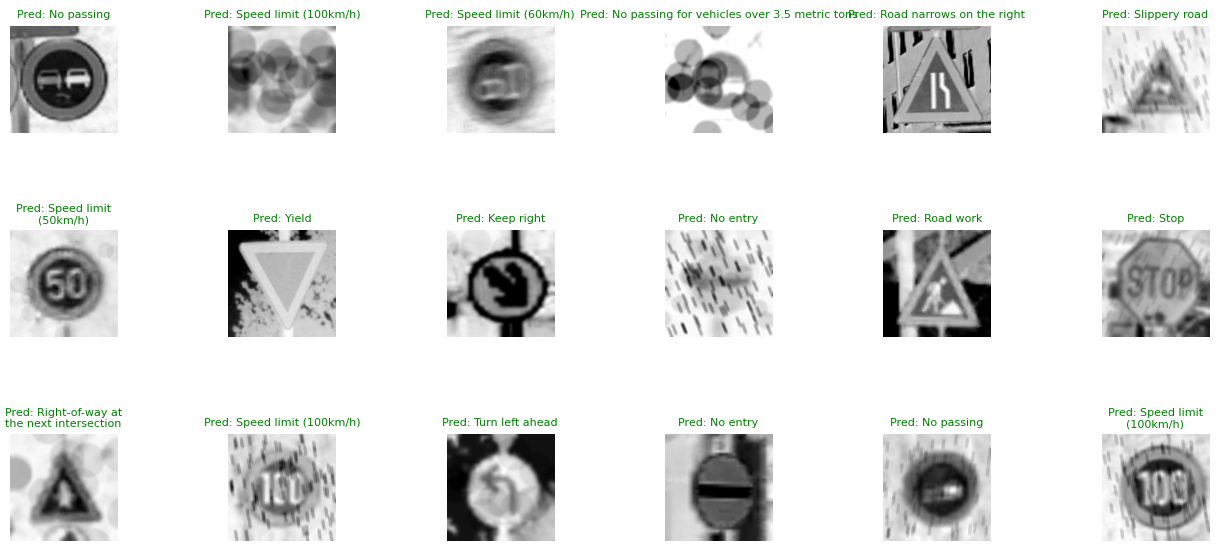

In [151]:
imgClassModel = models.mobilenet_v3_small(pretrained=False)
for params in imgClassModel.parameters():
    params.requires_grad = False
imgClassModel.classifier[3] = nn.Linear(in_features=1024, out_features=43)
imgClassModel.to(device)
imgClassModel = imgClassModel.eval()
imgClassModel.load_state_dict(torch.load('files/outputs/model.pth', map_location=device)['model_state_dict'])

yp = imgClassModel(X)
plot_images(X, y, yp, 3, 6)
print("Accuracy of model predictions: {}".format(sum(yp.max(dim=1)[1] == y)/len(y)))

**2.1 Untargeted attack using Fast Gradient Sign Method (FGSM), using the function fgsm().**

In [ ]:
def fgsm(model, X, y, epsilon):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

Accuracy of model predictions: 0.359375


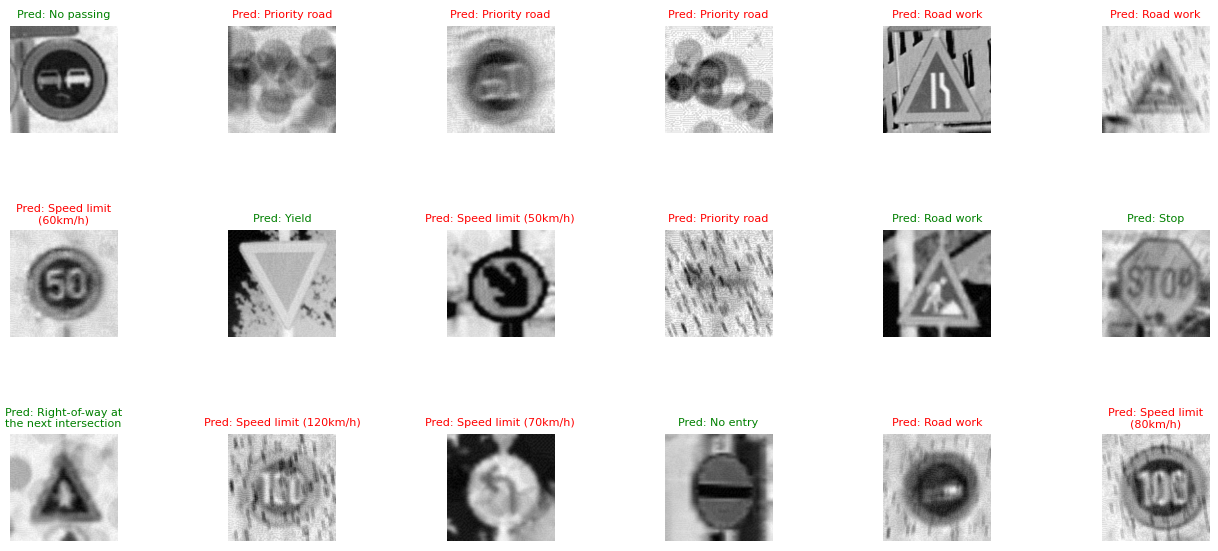

In [152]:
delta = fgsm(imgClassModel, X, y, 0.1)
yp = imgClassModel(X + delta)
plot_images(X+delta, y, yp, 3, 6)
print("Accuracy of model predictions: {}".format(sum(yp.max(dim=1)[1] == y)/len(y)))

**2.2 Untargeted attack using Projected Gradient Descent, using the function pgd_linf() (You may use the Projected Steepest Descent variant to accelerate the process).**

In [155]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + X.shape[0]*alpha*delta.grad.data).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

Accuracy of model predictions: 0.0625


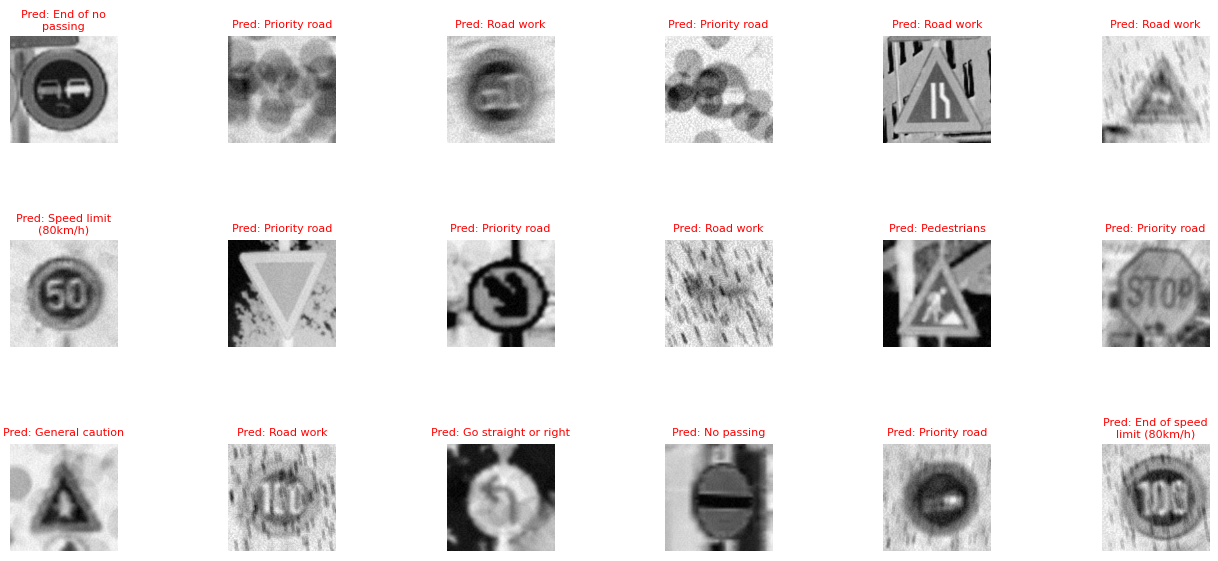

In [159]:
delta = pgd(imgClassModel, X, y, 0.1, 1e4, 1000)
yp = imgClassModel(X + delta)
plot_images(X+delta, y, yp, 3, 6)
print("Accuracy of model predictions: {}".format(sum(yp.max(dim=1)[1] == y)/len(y)))

**2.3 Targeted attack using Projected Gradient Descent, using the function pgd_linf_targ(), which aims to maximize logit of the target class y_targ and minimize logit of the true class y. You may choose any target class, but I suggest using "Speed Limit".**

**Target = Speed limit (100km/h)**

In [160]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = (yp[:,y_targ] - yp.gather(1,y[:,None])[:,0]).sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

Accuracy of model predictions: 0.03125


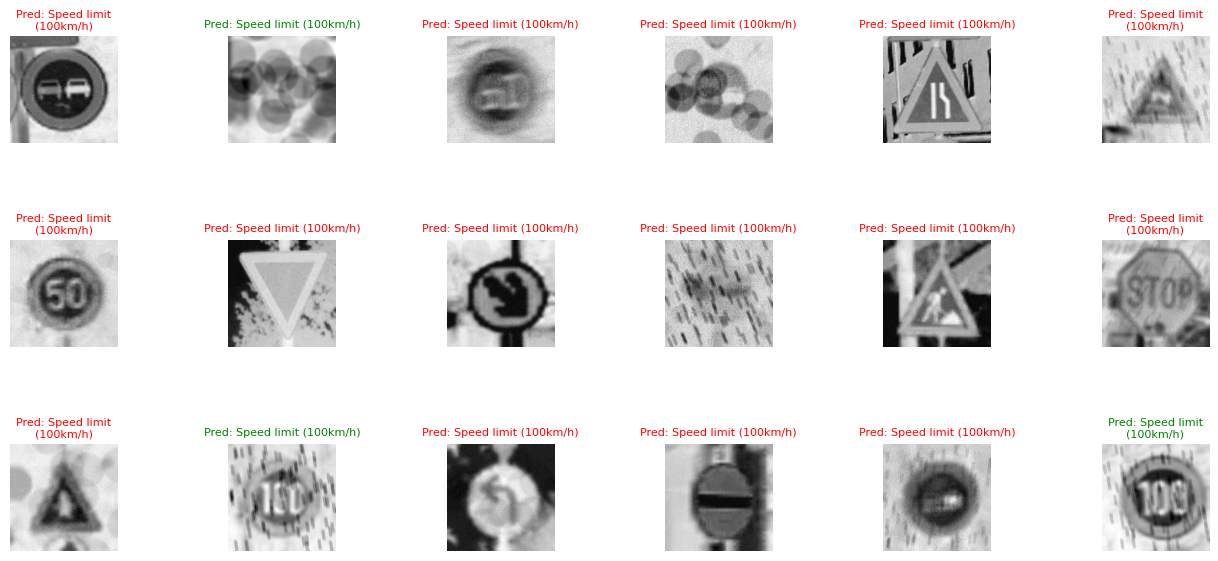

In [161]:
delta = pgd_linf_targ(imgClassModel, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=7)
yp = imgClassModel(X + delta)
plot_images(X+delta, y, yp, 3, 6)
print("Accuracy of model predictions: {}".format(sum(yp.max(dim=1)[1] == y)/len(y)))

**2.4 Targeted attack using Projected Gradient Descent, using the function pgd_linf_targ2(),  which  aims to maximize logit of the target class y_targ and minimize logit of all the other classes y'.**

**Target = Speed limit (100km/h)**

In [162]:
def pgd_linf_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    """ Construct targeted adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    for t in range(num_iter):
        yp = model(X + delta)
        loss = 2*yp[:,y_targ].sum() - yp.sum()
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

Accuracy of model predictions: 0.21875


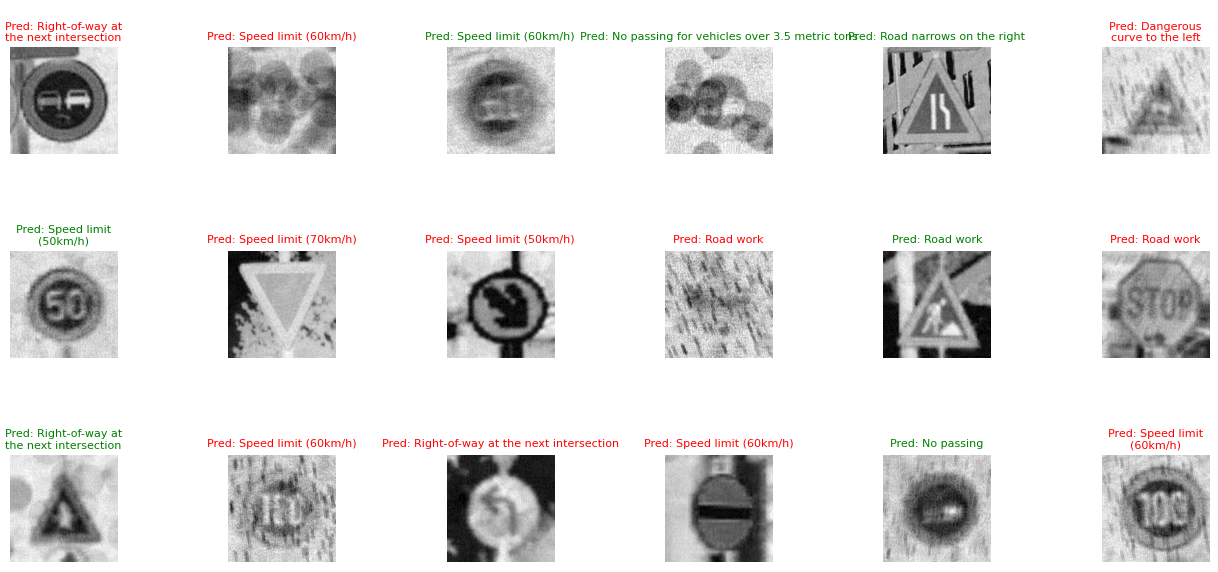

In [164]:
delta = pgd_linf_targ2(imgClassModel, X, y, epsilon=0.2, alpha=1e-2, num_iter=400, y_targ=7)
yp = imgClassModel(X + delta)
plot_images(X+delta, y, yp, 3, 6)
print("Accuracy of model predictions: {}".format(sum(yp.max(dim=1)[1] == y)/len(y)))